# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: Do autoencoders clean Gaussians?
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\lucan\AppData\Local\Temp\ipykernel_11568\242584434.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [316]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)
images_orig = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the original images tensor
  images_orig[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

# Move images to the GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
images = images.to(device)
images_orig = images_orig.to(device)

cuda:0


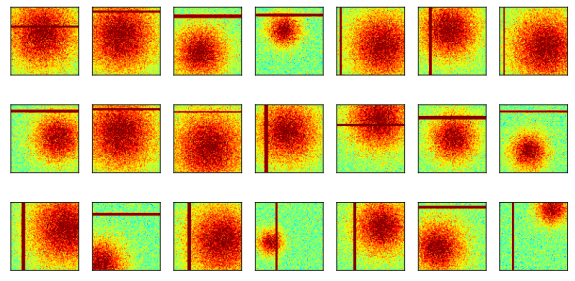

In [317]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images.cpu()[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

In [397]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,10,9,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(5, 5),

          nn.Conv2d(10,5,5,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(3, 3),

          # nn.Conv2d(5,3,3,padding=1),
          # nn.ReLU(),
          # nn.AvgPool2d(2, 2),
      )
      
      # decoding layer
      self.dec = nn.Sequential(
          # nn.ConvTranspose2d(3,5,3, stride=5),
          # nn.ReLU(),

          nn.ConvTranspose2d(5,10,5, stride=4, padding=1),
          nn.ReLU(),

          nn.ConvTranspose2d(10,1,9, stride=5, padding=4),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet().to(device)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([10, 1, 91, 91])


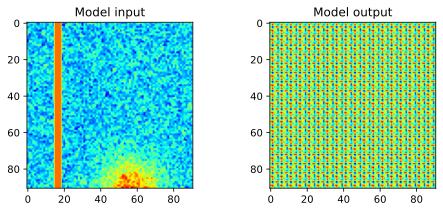

In [398]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(images[:10,:,:,:])
lossfun(yHat, images_orig[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images.cpu()[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat.cpu()[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [399]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 85, 85]             820
              ReLU-2           [-1, 10, 85, 85]               0
         AvgPool2d-3           [-1, 10, 17, 17]               0
            Conv2d-4            [-1, 5, 15, 15]           1,255
              ReLU-5            [-1, 5, 15, 15]               0
         AvgPool2d-6              [-1, 5, 5, 5]               0
   ConvTranspose2d-7           [-1, 10, 19, 19]           1,260
              ReLU-8           [-1, 10, 19, 19]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]             811
Total params: 4,146
Trainable params: 4,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.26
Params size (MB): 0.02
Estimated Total Size (MB): 1.31
-----------------------------------------------

# Create a function that trains the model

In [400]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]
    y = images_orig[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,y)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [401]:
# test the model on a bit of data
losses,net = function2trainTheModel()

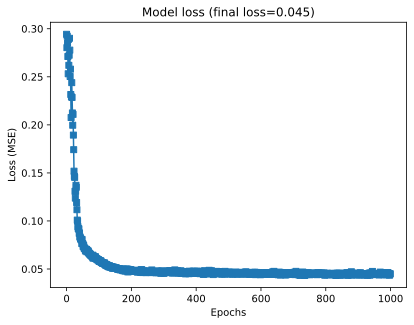

In [402]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

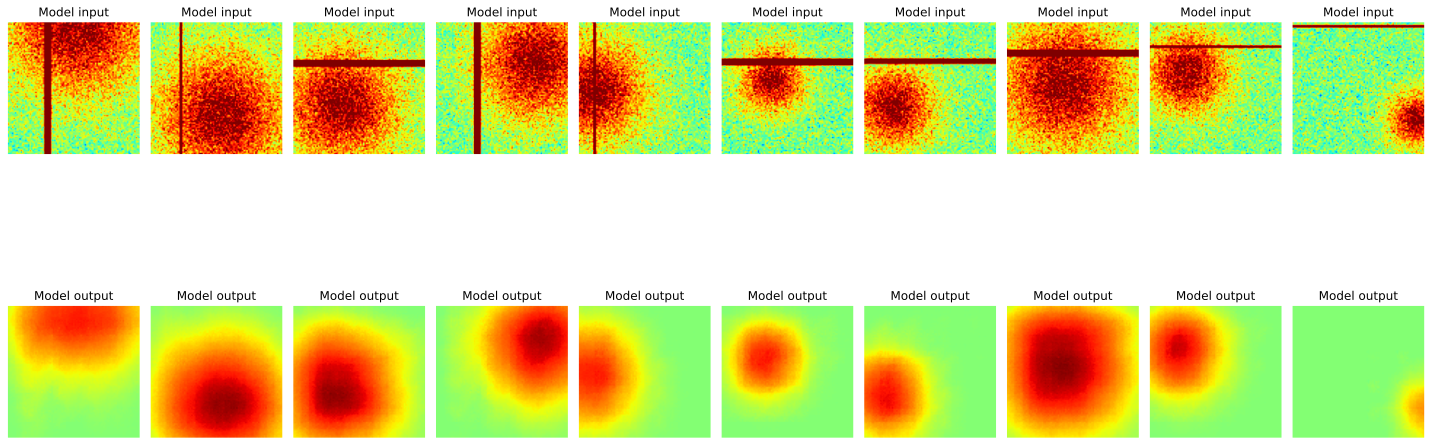

In [403]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(20,10))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:].cpu() ).detach()
  O = torch.squeeze( yHat[i,0,:,:].cpu() ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.tight_layout()
plt.show()